In [1]:
from ASGCNN.Encoder import Encoder_structure, Encoder_element, Encoder_edge, Encoder_angle, Graph_data_loader
from ASGCNN.Trainer import Trainer, setup_seed
from ASGCNN.Model import CGCNN

import zipfile
import pandas as pd

Here we show the other model architectures supported by the code in addition to ASGCNN.  
# CGCNN
In addition to **ASGCNN**, you can also import [**CGCNN**](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.145301) module from **Model** script. This module is the same as ASGCNN, except that its input supports only one graph structure. The two graphs in the ASGCNN can also have different graph structures, for example, the slab graph and bulk graph in [**SGCNN**](https://pubs.acs.org/doi/10.1021/acs.chemmater.9b03686).  

Let us try to train a **CGCNN** model to predict **formation energy**, **e above hull** and **lattice constant** for Heusler alloy. 
If you want to train only **one target**, change the **target** parameters in **Graph_data_loader**, the **regre_dim** parameters in the model, and **metric**, **target_dims** parameters in the **Trainer**.  

First define **Encoder_structure** , **Encoder_element** and **Encoder_edge**.   

In [3]:
Es = Encoder_structure(cutoff=3.36)
En = Encoder_element(features=['atomic number', 'group', 'period'])# ,elements=['Fe',.......]
Ee = Encoder_edge(features=['radiusg'])

Then unzip the bulk structure files and build the dataset by **Graph_data_loader**.

In [3]:
# unzip bulk structure file
with zipfile.ZipFile(r'structures/All_bulk_fix_lattice.zip', 'r') as zip_ref:
    zip_ref.extractall(r'structures/bulk_structures')

# setyp random seed
setup_seed(4311)

# build training set
Loader_train_bulk = Graph_data_loader(250)
Loader_train_bulk.load_data(
    data_excel='data/Bulk_train_1000.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation', 'lattice_constant', 'E_above_hull'])

# build validation set
Loader_valid_bulk = Graph_data_loader(134)
Loader_valid_bulk.load_data(
    data_excel='data/Bulk_valid_134.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation', 'lattice_constant', 'E_above_hull'])

Load graph:   0%|          | 0/1000 [00:00<?, ?g/s]

Load graph:   0%|          | 0/134 [00:00<?, ?g/s]

In [4]:
# apply node and edge features
Loader_train_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Loader_valid_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Apply feature:   0%|          | 0/1000 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/134 [00:00<?, ?g/s]

Now, we can define a CGCNN model and train it.  

More details about model can be found at:

In [ ]:
help(CGCNN.__init__)

In [6]:
model = CGCNN(
    node_feat_length=En.feature_lentgh_total,
    edge_feat_length=Ee.feature_length_total,
    embed_feat_length=20,
    conv_num=3,
    fcl_dims=[20, 10],
    mlp_acti='sigmoid',
    task_typ='regre',
    regre_dim=[3])

In [7]:
t = Trainer(
    Module=model,
    Dataloader_train=Loader_train_bulk, 
    Dataloader_valid=Loader_valid_bulk,
    init_lr=0.1,
    metric='hyb',
    metric_para={'weight':[1,1,1]},
    scheduler_para=200,
    target_dims=[1,1,1])

In [8]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

Let us check out training results

In [9]:
t.calculate_static()

{'train': {'r2_0': 0.9872722803704762,
  'mae_0': 0.020677708,
  'mse_0': 0.000753371,
  'rmse_0': 0.027447604,
  'r2_1': 0.9953073971370053,
  'mae_1': 0.01601635,
  'mse_1': 0.00043252602,
  'rmse_1': 0.02079726,
  'r2_2': 0.9644875794697341,
  'mae_2': 0.022361603,
  'mse_2': 0.00084384164,
  'rmse_2': 0.029048953},
 'valid': {'r2_0': 0.9130245446040459,
  'mae_0': 0.049856547,
  'mse_0': 0.0046115927,
  'rmse_0': 0.06790871,
  'r2_1': 0.9858490854809067,
  'mae_1': 0.02502314,
  'mse_1': 0.0010812392,
  'rmse_1': 0.032882202,
  'r2_2': 0.8284518134471838,
  'mae_2': 0.04527507,
  'mse_2': 0.0033776544,
  'rmse_2': 0.05811759},
 'test': {}}

It can be seen that the model has the most accurate prediction of the **second target (lattice constant)**, and the prediction ability of **formation energy** is second, and it is hard to predict **energy above hull**.   

Let's take a look at the training result of formation energy by **parity plot**

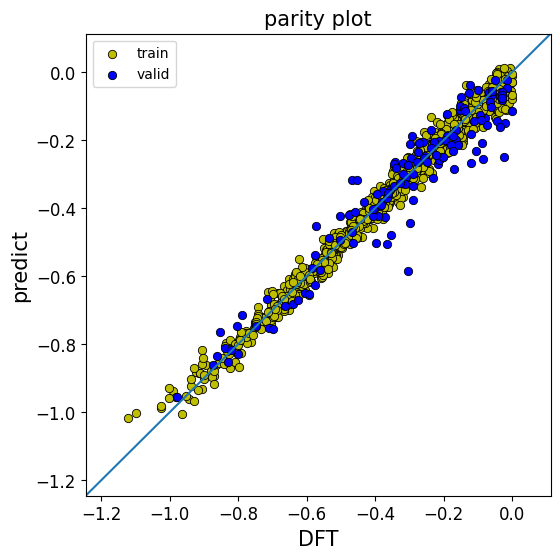

In [10]:
t.show_result(ti=0)

# Multy fully connection layers

By setting **fcl_dims** to a list of lists, the model can use more than one fully connection layers to predict the target values.  

In this case, the number of dimensions of target needs to be the same as the number of fully connected layers, and you can pass in an empty list at this point to represent predictions directly from the pooled features.  

The previous model predicted E_above_hull poorly, now let's try to predict each of the three target values using three different fully connected layers. And give E_above_hull's prediction a deeper fully connection layer and a higher **weight** in the loss function (metric).

In [12]:
model = CGCNN(
    node_feat_length=En.feature_lentgh_total,
    edge_feat_length=Ee.feature_length_total,
    embed_feat_length=20,
    conv_num=3,
    fcl_dims=[[10],[],[50,30,10]], # multy fully connection layers
    mlp_acti='sigmoid',
    task_typ='regre',
    regre_dim=[1,1,1])

t = Trainer(
    Module=model,
    Dataloader_train=Loader_train_bulk, 
    Dataloader_valid=Loader_valid_bulk,
    init_lr=0.1,
    metric='hyb',
    metric_para={'weight':[0.6,0.1,2]}, # different weight for each target
    scheduler_para=200,
    target_dims=[1,1,1])

In [13]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

It can be seen that the R$^2$ score of the modified model for E_above_hull in the training set and the validation set increases from 0.964 to 0.988 and from 0.828 to 0.857 respectively

In [14]:
t.calculate_static()

{'train': {'r2_0': 0.985240121718915,
  'mae_0': 0.022731295,
  'mse_0': 0.00087365723,
  'rmse_0': 0.029557694,
  'r2_1': 0.9767315679071257,
  'mae_1': 0.036942746,
  'mse_1': 0.0021446953,
  'rmse_1': 0.046310853,
  'r2_2': 0.9880021333564127,
  'mae_2': 0.013238086,
  'mse_2': 0.00028509178,
  'rmse_2': 0.01688466},
 'valid': {'r2_0': 0.9287483230023436,
  'mae_0': 0.048100315,
  'mse_0': 0.00377789,
  'rmse_0': 0.061464544,
  'r2_1': 0.9537519077361639,
  'mae_1': 0.046474356,
  'mse_1': 0.0035337117,
  'rmse_1': 0.05944503,
  'r2_2': 0.8572064450859099,
  'mae_2': 0.038683478,
  'mse_2': 0.0028114973,
  'rmse_2': 0.053023554},
 'test': {}}

# Global feature
You can use **add_global_feat** in the **Graph_data_loader** to add global feature to graphs as in the [**SE-CGCNN**](https://d.wanfangdata.com.cn/periodical/gsyxb202302012) and [**MEGNet**](https://pubs.acs.org/doi/10.1021/acs.chemmater.9b01294). Global feature can concatenate directly onto node or edge features, or add to graph first, then concatenate to the pooling feature or the linear final for prediction in fully connection layers during the training process (When a global feature is added and you have two types of graphs, it will be added to the last graph).   

After adding global features you can also use the **MGConv** convolution layer to update global features and use them in the messaging passing process.

More details can be found at:

In [ ]:
help(Graph_data_loader.add_global_feat)

Now we try to predict the formation energy with lattice constants and energy above hull as global features.  
Reload the data with one target:

In [15]:
# build validation set
Loader_train_bulk = Graph_data_loader(250)
Loader_train_bulk.load_data(
    data_excel='data/Bulk_train_1000.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation'])

# build validation set
Loader_valid_bulk = Graph_data_loader(134)
Loader_valid_bulk.load_data(
    data_excel='data/Bulk_valid_134.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation'])

# apply node and edge features
Loader_train_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Loader_valid_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Load graph:   0%|          | 0/1000 [00:00<?, ?g/s]

Load graph:   0%|          | 0/134 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/1000 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/134 [00:00<?, ?g/s]

Get numpy format features from the table and add them to the dataset

In [16]:
df_train = pd.read_excel(r'data/Bulk_train_1000.xlsx',index_col=0)
df_valid = pd.read_excel(r'data/Bulk_valid_134.xlsx', index_col=0)
df_train[['E_formation', 'E_above_hull']].values

array([[-0.63634772,  0.00212674],
       [-0.02319799,  0.41365819],
       [-0.82380039,  0.00633029],
       ...,
       [-0.37319613,  0.01472392],
       [-0.52834174,  0.24321792],
       [-0.28996478,  0.18311992]])

In [17]:
# add global feature to graph
Loader_train_bulk.add_global_feat(df_train[['E_formation', 'E_above_hull']].values)
Loader_valid_bulk.add_global_feat(df_valid[['E_formation', 'E_above_hull']].values)

Add parameters related to global features when defining the model. If the global feature is concatenated to the node or edge feature, modify the length parameter of the node and edge feature.

In [18]:
model = CGCNN(
    node_feat_length=En.feature_lentgh_total,
    edge_feat_length=Ee.feature_length_total,
    embed_feat_length=20,
    conv_num=3,
    conv_typ='MGConv',
    fcl_dims=[[60,30,10]],
    mlp_acti='sigmoid',
    task_typ='regre',
    regre_dim=[1],
    use_global_feat=True,
    global_feat_place='pool',
    global_feat_dim=2,
)

t = Trainer(
    Module=model,
    Dataloader_train=Loader_train_bulk, 
    Dataloader_valid=Loader_valid_bulk,
    init_lr=0.1,
    metric='mae',
    scheduler_para=200,
    target_dims=[1])

In [19]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

Compared with the previous model, this model can predict the formation energy much better

In [20]:
t.calculate_static()

{'train': {'r2_0': 0.9995491099102164,
  'mae_0': 0.0037091132,
  'mse_0': 2.6688796e-05,
  'rmse_0': 0.00516612},
 'valid': {'r2_0': 0.9995860522866695,
  'mae_0': 0.0035538722,
  'mse_0': 2.1948243e-05,
  'rmse_0': 0.0046848953},
 'test': {}}

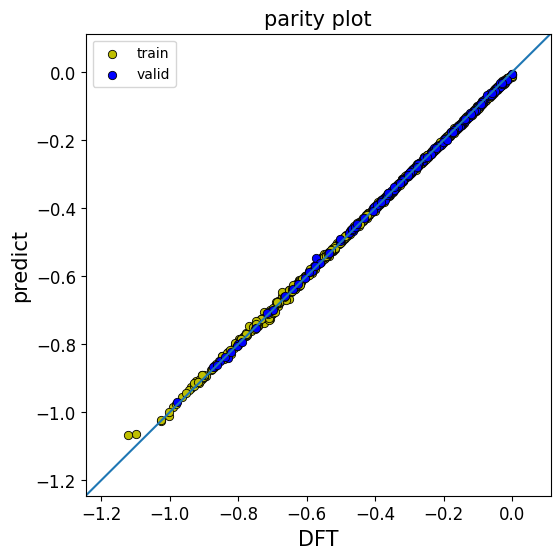

In [21]:
t.show_result()

# Line graph
You can add additional **line graphs** to dataset, as is the case with [**ALIGNN**](https://www.nature.com/articles/s41524-021-00650-1). The line graph uses edges as nodes and angles as edges, so angle information can be introduced.  

Now try using line graphs to increase the predictive power of formation energy. Before adding a line graph, you need to add edge features to the graph.   

Line graph can be saved by setting **file_names_lg** on **save_data**, and loaded by **lg_bins** at **load_data**. Anyway, these line graph data are large and are not recommended to be saved. You can generate it when needed, or save it without adding angle feature.

Rebuild data loaders at first:

In [22]:
# build training set
Loader_train_bulk = Graph_data_loader(250)
Loader_train_bulk.load_data(
    data_excel='data/Bulk_train_1000.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation'])

# build validation set
Loader_valid_bulk = Graph_data_loader(134)
Loader_valid_bulk.load_data(
    data_excel='data/Bulk_valid_134.xlsx', 
    encoders=[Es], 
    file_paths=['structures/bulk_structures'], 
    file_columns=['composition'], 
    target=['E_formation'])

# apply node and edge features
Loader_train_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Loader_valid_bulk.apply_feature(
    encoder_element=[En],
    encoder_edge=[Ee])

Load graph:   0%|          | 0/1000 [00:00<?, ?g/s]

Load graph:   0%|          | 0/134 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/1000 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/134 [00:00<?, ?g/s]

Using **add_line_graph** to add line graphs and then use **Encoder_angle** to define angle features. There are now two angular features to choose from: projecting the cos value onto a **Gaussian (gaussian)** or a **Fourier (fourier)** basis function.

In [23]:
# generate line graph
Loader_train_bulk.add_line_graph()
Loader_valid_bulk.add_line_graph()

# add angle feature
Ea = Encoder_angle(features=['gaussian', 'fourier'])
Loader_train_bulk.apply_feature_angle(encoder_angle=[Ea])
Loader_valid_bulk.apply_feature_angle(encoder_angle=[Ea])

Apply feature:   0%|          | 0/1000 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/134 [00:00<?, ?g/s]

Enable line graph learning by adding the length of the **angle_feat_length** when defining the model.   

In this case, the convolution layer type (**conv_type**) and the number of convolution times (**conv_number**) need to be defined in a list. Similar to the convolution method in **ALIGNN**, linear graph and graph are convolved sequentially with the first type convolution layer, then the graph is convolved multiple times individually with the second type convolution layer.   

And note that some convolution layers like MGConv can not be used to update features on line graphs.

In [24]:
model = CGCNN(
    node_feat_length=En.feature_lentgh_total,
    edge_feat_length=Ee.feature_length_total,
    angle_feat_length=Ea.feature_length_total,
    embed_feat_length=20,
    conv_typ=['EGate', 'CGConv'],
    conv_num=[2, 3],
    fcl_dims=[20,40,20],
    mlp_acti='sigmoid',
    task_typ='regre',
    regre_dim=[1],
)

t = Trainer(
    Module=model,
    Dataloader_train=Loader_train_bulk, 
    Dataloader_valid=Loader_valid_bulk,
    init_lr=0.1,
    metric='mae',
    metric_para={},
    scheduler_para=200,
    target_dims=[1])

In [25]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

In [26]:
t.calculate_static()

{'train': {'r2_0': 0.9972574334283643,
  'mae_0': 0.009447935,
  'mse_0': 0.00016233623,
  'rmse_0': 0.012741123},
 'valid': {'r2_0': 0.883592653705417,
  'mae_0': 0.04957165,
  'mse_0': 0.0061721243,
  'rmse_0': 0.07856287},
 'test': {}}

# Cluster pooling 

You can pool the features of only a subset of atomic nodes using **cluster pooling**. As in the [**BE-CGCNN**](https://www.nature.com/articles/s41467-023-38758-1) and [**LEPool-model**](https://linkinghub.elsevier.com/retrieve/pii/S2210271X23001433) model, only the node features of  adsorbed molecules and their adjacent atoms are considered.    

To use this method, first run the **add_cluster_feat** method on the **Graph_data_loader**. This method is used to set which elements are pooled and whether to consider their surrounding atoms. This method is shown below to train a model that predicts adsorption energy:

In [36]:
# load training set
Loader_train_slab = Graph_data_loader(250)
Loader_train_slab.load_data(
    data_excel='data/Train_data_5000.csv', 
    encoders=['data/Graph_slab_train.bin'], 
    target=['Gads'])

# load validation set
Loader_valid_slab = Graph_data_loader(250)
Loader_valid_slab.load_data(
    data_excel='data/Valid_data_500.csv', 
    encoders=['data/Graph_slab_valid.bin'], 
    target=['Gads'])

Because considering the surrounding atoms requires reloading the dataset under the new version, we pool only the nodes of the molecules here

In [37]:
Loader_train_slab.add_cluster_feat(element_in_cluster=[1, 7], include_neibor=False, cutoff=5)
Loader_valid_slab.add_cluster_feat(element_in_cluster=[1, 7], include_neibor=False, cutoff=5)

set **pool_typ** to 'cluster'

In [40]:
model = CGCNN(
    node_feat_length=Loader_train_slab.graphs[0][0].ndata['h_v'].shape[1],
    edge_feat_length=Loader_train_slab.graphs[0][0].edata['h_e'].shape[1],
    embed_feat_length=20,
    conv_typ='EGate',
    conv_num=3,
    pool_typ='cluster',
    fcl_dims=[40,20],
    mlp_acti='sigmoid',
    task_typ='regre',
    regre_dim=[1],
)

t = Trainer(
    Module=model,
    Dataloader_train=Loader_train_slab, 
    Dataloader_valid=Loader_valid_slab,
    init_lr=0.1,
    metric='mae',
    metric_para={},
    scheduler_para=200,
    target_dims=[1])

In [41]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

The results of training are not very good, indicating that the adsorption sites and neighboring atoms of molecules under the current task can not be ignored.

In [42]:
t.calculate_static()

{'train': {'r2_0': 0.6746256113128579,
  'mae_0': 0.49449292,
  'mse_0': 0.47298706,
  'rmse_0': 0.68774056},
 'valid': {'r2_0': 0.7293389965202466,
  'mae_0': 0.47000903,
  'mse_0': 0.4036608,
  'rmse_0': 0.6353431},
 'test': {}}